In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import re
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner'])
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv('/kaggle/input/cyberbullying/suspicious_tweets.csv')

In [3]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  Something for nothing doesn't exist. What will...    2
1       53855  53574                                             #NAME?    7

In [4]:
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


In [5]:
df_labels = df['label']
df_labels.head(11)

0     1
1     1
2     1
3     0
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: label, dtype: int64

In [6]:
#It has 60,000 records (tweets) and 2 fields (the content of the tweet and a sentiment rating).
df.shape

(60000, 3)

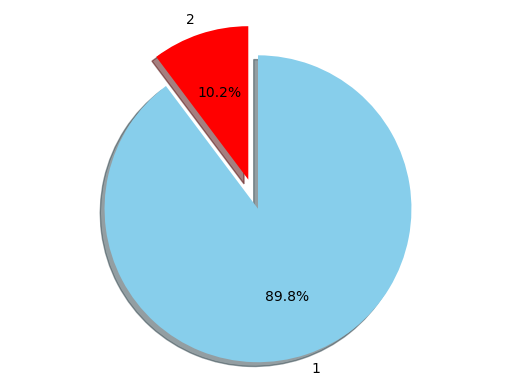

In [7]:
count_Class = pd.value_counts(df.label, sort = True)

# Data to Plot
labels = '2','1'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)

# Plot
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [8]:
#We open by rating tweets (0="suspicious", 1="non suspicious").
values_count=df['label'].value_counts()
values_count

1    53855
0     6145
Name: label, dtype: int64

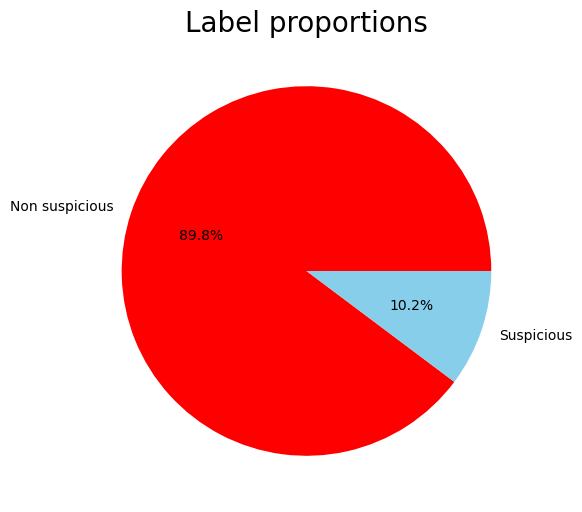

In [9]:
plt.figure(figsize=(18,6))
plt.pie(values_count,labels=['Non suspicious','Suspicious'],colors=['red', 'skyblue'], autopct = '%1.1f%%')
plt.title("Label proportions",fontsize=20)
plt.show()

In [10]:
#We define a function that takes samples of size N, from the 2 subsets that make up the dataset ("suspiciuss" and "non suspicious" tweets).
#Then we append them and shuffle over the new set. The function returns a new "train" dataset.
def balance_classes(data):
    #Definimos N=5.000
    n_Class = 5000
    label_0=data[data['label']==0].sample(n=n_Class)
    label_1=data[data['label']==1].sample(n=n_Class)
    train = pd.concat([label_1,label_0])
    train=shuffle(train)
    return train

# For this work we will use text mining techniques. For this we will implement NLTK (Natural Language Toolkit), a library for
#natural language processing. Our goal will be tokenize the tweets and build "bags of words" with them.
#We remove the punctuation of the tweets.
def remove_punctuation(text):
  for punctuation in string.punctuation:
    text=text.replace(punctuation,'')
  return text

#We remove stopwords from tweets.
def remove_stopwords(text,is_lower_case=True):
  tokenizer = ToktokTokenizer()

  stop_words_list = nltk.corpus.stopwords.words('english')
  stop_words_list.remove('no')
  stop_words_list.remove('not')

  tokens=tokenizer.tokenize(text)
  tokens=[token.strip() for token in tokens]
  if is_lower_case:
    filterd_tokens=[token for token in tokens if token not in stop_words_list]
  else:
    filterd_tokens=[token for token in tokens if token.lower() not in stop_words_list]
  filterd_text=' '.join(filterd_tokens)
  return filterd_text

#We remove special characters.
def remove_special_characters(text):
  text=re.sub('[^a-zA-z0-9\s]','',text)
  return text

#We remove characters from HTML
def remove_html(text):
  html_pattran=re.compile('<.*?>')
  return html_pattran.sub(r' ',text)

#We remove characters from URL
def remove_url(text):
  url=re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r' ',text)

#we remove numbers
def remove_numbers(text):
  text=''.join([i for i in text if not i.isdigit()])
  return text

def cleanse(word):
  rx=re.compile(r'\D*\d')
  if rx.match(word):
    return ' '
  return word


def alpha_numeric(strings):
  nstrings=[" ".join(filter(None,(cleanse(word) for word in string.split()))) for string in strings.split()]
  str1=" ".join(nstrings)
  return str1

#We pass the tweets through a lemmatizer (Lemmatization)
def lemmatize(text):
  text=nlp(text)
  text=" ".join([word.lemma_ if word.lemma_!='-PRON-' else word for word in text])
  return text

In [11]:
def clean_dataset(df):
  df['message'] = df['message'].apply(remove_punctuation)
  df['message'] = df['message'].apply(remove_stopwords)
  df['message'] = df['message'].apply(remove_special_characters)
  df['message'] = df['message'].apply(remove_html)
  df['message'] = df['message'].apply(remove_url)
  df['message'] = df['message'].apply(remove_numbers)
  df['message'] = df['message'].apply(alpha_numeric)
  df['message'] = df['message'].apply(lemmatize)
  return df

cleaned_data = df.pipe(balance_classes).pipe(clean_dataset)
     

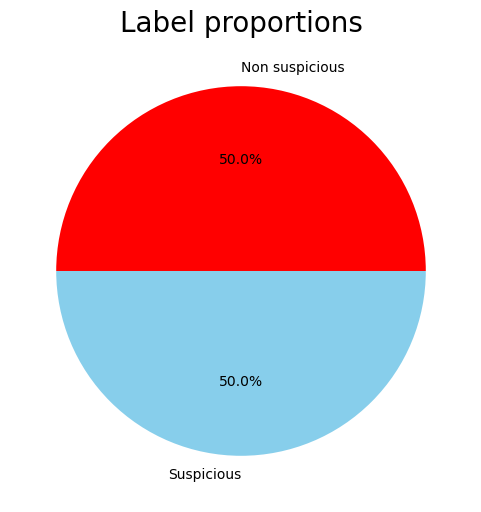

In [12]:
#Here we graph the new distribution of the already balanced classes
values_count=cleaned_data['label'].value_counts()
values_count

plt.figure(figsize=(18,6))
plt.pie(values_count,labels=['Non suspicious','Suspicious'],colors=['red', 'skyblue'], autopct = '%1.1f%%')
plt.title("Label proportions",fontsize=20)
plt.show()

In [13]:
X=cleaned_data['message'].values
y=cleaned_data['label'].values     

In [14]:
vector=TfidfVectorizer(lowercase=False)
vector.fit(X)
X=vector.fit_transform(X)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, shuffle=True, random_state = 5, stratify=y)

In [16]:
random=RandomForestClassifier()
random.fit(X_train,y_train)
random_pred=random.predict(X_test)

print(f'The score for random forest with the train set is {random.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {random.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,random_pred)}')

The score for random forest with the train set is 1.0
The score for random forest with the test set is 0.8726666666666667
The accuracy for random forest is 0.8726666666666667


In [17]:
random1=XGBClassifier()
random1.fit(X_train,y_train)
random_pred1=random1.predict(X_test)

print(f'The score for random forest with the train set is {random1.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {random1.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,random_pred1)}')

The score for random forest with the train set is 0.8932857142857142
The score for random forest with the test set is 0.869
The accuracy for random forest is 0.869


              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1500
           1       0.81      0.97      0.88      1500

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87      3000



<Axes: >

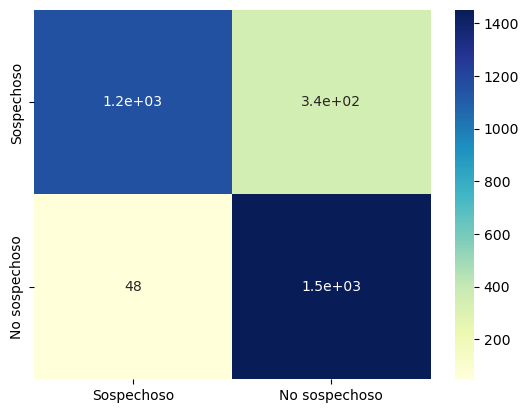

In [18]:
print(classification_report(y_test,random_pred1))
cn=confusion_matrix(y_test,random_pred1)
sns.heatmap(cn,annot=True,cmap='YlGnBu', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1500
           1       0.82      0.96      0.88      1500

    accuracy                           0.87      3000
   macro avg       0.89      0.87      0.87      3000
weighted avg       0.89      0.87      0.87      3000



<Axes: >

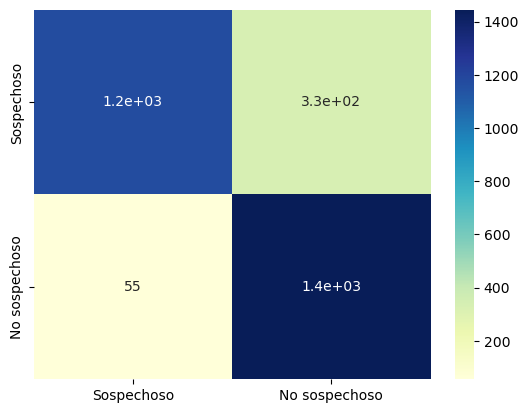

In [19]:
print(classification_report(y_test,random_pred))
cn=confusion_matrix(y_test,random_pred)
sns.heatmap(cn,annot=True,cmap='YlGnBu', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [20]:
scores = cross_val_score(random, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

[0.84071429 0.86714286 0.86142857 0.85285714 0.86642857]
0.8577142857142857


### Adding Enhancements

In [21]:
def random_search(model,X_train,Y_train,param_grid):
  random=RandomizedSearchCV(estimator=model,param_distributions=param_grid,n_iter=20,cv=3,verbose=2,random_state=42,n_jobs=-1)
  random.fit(X_train,y_train)
  print(random.best_params_)

In [22]:
rf_para_grid={
  'n_estimators': list(range(150, 301, 50)),
  'max_features': ['auto', 'sqrt'],
  'max_depth': [int(x) for x in np.linspace(3, 10, num = 3)],
  'min_samples_split': [2, 5],
  'min_samples_leaf': [1, 2],
  'bootstrap': [True, False]
}

random_search(RandomForestClassifier(),X_train,y_train,rf_para_grid)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [23]:
random_rnd=RandomForestClassifier(**{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'bootstrap': False})
random_rnd.fit(X_train,y_train)
random_rnd_pred=random_rnd.predict(X_test)

print(f'The score for random forest with the train set is {random_rnd.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {random_rnd.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,random_rnd_pred)}')

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


The score for random forest with the train set is 0.874
The score for random forest with the test set is 0.837
The accuracy for random forest is 0.837


              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1500
           1       0.78      0.95      0.85      1500

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.83      3000
weighted avg       0.85      0.84      0.83      3000



<Axes: >

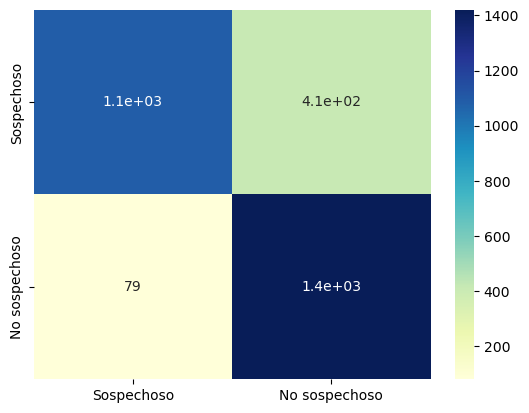

In [24]:
print(classification_report(y_test,random_rnd_pred))
cn=confusion_matrix(y_test,random_rnd_pred)
sns.heatmap(cn,annot=True,cmap='YlGnBu', xticklabels=['Sospechoso','No sospechoso'],yticklabels=['Sospechoso','No sospechoso'])

In [25]:
scores = cross_val_score(random_rnd, X_train,y_train, cv=5)
print(scores)
print(scores.mean())

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

[0.79785714 0.85214286 0.83857143 0.82357143 0.83285714]
0.829


In [26]:
with open('/kaggle/working/model.pkl', 'wb') as f_model:
    pickle.dump(random_rnd, f_model)

In [27]:
with open('/kaggle/working/model.pkl', 'rb') as f_model:
    model = pickle.load(f_model)

In [28]:
model_pred=model.predict(X_test)

print(f'The score for random forest with the train set is {model.score(X_train, y_train)}')
print(f'The score for random forest with the test set is {model.score(X_test, y_test)}')
print(f'The accuracy for random forest is {accuracy_score(y_test,model_pred)}')

The score for random forest with the train set is 0.874
The score for random forest with the test set is 0.837
The accuracy for random forest is 0.837


## Testing model

In [38]:
text= 'i will steal the wallet today'
text=[text]
text_int=vector.transform(text)
prediction=model.predict(text_int)
prediction[0]

0

In [32]:
text='i love computer science'
text=[text]
text_int=vector.transform(text)
prediction=model.predict(text_int)
prediction[0]

1

In [37]:
text='i killed someone today'
text=[text]
text_int=vector.transform(text)
prediction=model.predict(text_int)
prediction[0]

1

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.5s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   1.8s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=3, max_featur